In [1]:
import pandas as pd
import seaborn as sns
import time
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import re

from mlxtend.plotting import plot_confusion_matrix

## Information about the dataset(data about the data) (Metadata)

In [2]:
used = False
def getFeatureDF():
    global used
    if used:
        return
    from scipy.stats import chi2_contingency
    data = pd.read_csv("malware-benign.csv", encoding="utf-8", low_memory=False, na_values="?")
    input_columns = data.columns[:-1]
    output_column = data.columns[-1]

    contingency_table = pd.crosstab(data[input_columns[0]], data[output_column])

    chi2_p={}
    for column in input_columns:
        contingency_table = pd.crosstab(data[column], data[output_column])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        chi2_p[column] = (chi2, p)

    new_chi2_p = {key: val for key, val in chi2_p.items() if val[1] < 0.05}

    chi2_vals = [val[0] for val in new_chi2_p.values()]

    chi2_vals.sort(reverse=True)

    final_chi2_p = {key: val for key, val in new_chi2_p.items() if val[0] > 675}

    imp_cols=list(final_chi2_p.keys())
    imp_cols+=['class']

    feature_df = pd.read_csv("features.csv", header=None, names=["X", "Category"])

    feature_df=feature_df[feature_df['X'].isin(imp_cols)]  # only keep the important features
    
    return feature_df

In [3]:
data = pd.read_csv("malware-benign.csv", encoding="utf-8", low_memory=False, na_values="?")
data.head(10)

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,S
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,S
6,0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,S
7,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
8,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,S
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,S


In [4]:
data.shape

(15043, 216)

## Chi square test for correlation

In [5]:
from scipy.stats import chi2_contingency

In [6]:
input_columns = data.columns[:-1]
output_column = data.columns[-1]

In [7]:
contingency_table = pd.crosstab(data[input_columns[0]], data[output_column])
contingency_table

class,B,S
transact,,
0,3390,5241
1,6088,324


In [8]:
chi2_p={}

In [9]:
for column in input_columns:
    contingency_table = pd.crosstab(data[column], data[output_column])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print("Column: ", column)
    print("Chi2 value: ", chi2)
    print("P value: ", p)
    print("=====================================")
    chi2_p[column] = (chi2, p)

Column:  transact
Chi2 value:  4889.188627757803
P value:  0.0
Column:  onServiceConnected
Chi2 value:  4735.446265536381
P value:  0.0
Column:  bindService
Chi2 value:  4697.901403097391
P value:  0.0
Column:  attachInterface
Chi2 value:  4574.506563467601
P value:  0.0
Column:  ServiceConnection
Chi2 value:  4674.157449714762
P value:  0.0
Column:  android.os.Binder
Chi2 value:  4611.4626717692745
P value:  0.0
Column:  SEND_SMS
Chi2 value:  4469.596590986639
P value:  0.0
Column:  Ljava.lang.Class.getCanonicalName
Chi2 value:  3288.926104853883
P value:  0.0
Column:  Ljava.lang.Class.getMethods
Chi2 value:  2863.767280520132
P value:  0.0
Column:  Ljava.lang.Class.cast
Chi2 value:  2924.6314282082376
P value:  0.0
Column:  Ljava.net.URLDecoder
Chi2 value:  2969.466033130396
P value:  0.0
Column:  android.content.pm.Signature
Chi2 value:  2856.991269694143
P value:  0.0
Column:  android.telephony.SmsManager
Chi2 value:  2837.9435318902424
P value:  0.0
Column:  READ_PHONE_STATE
Chi2 

In [10]:
len(chi2_p)

215

In [11]:
sum([1 for key, val in chi2_p.items() if val[1] < 0.05])    # p==0.05 is the threshold

203

In [12]:
new_chi2_p = {key: val for key, val in chi2_p.items() if val[1] < 0.05}
new_chi2_p

{'transact': (4889.188627757803, 0.0),
 'onServiceConnected': (4735.446265536381, 0.0),
 'bindService': (4697.901403097391, 0.0),
 'attachInterface': (4574.506563467601, 0.0),
 'ServiceConnection': (4674.157449714762, 0.0),
 'android.os.Binder': (4611.4626717692745, 0.0),
 'SEND_SMS': (4469.596590986639, 0.0),
 'Ljava.lang.Class.getCanonicalName': (3288.926104853883, 0.0),
 'Ljava.lang.Class.getMethods': (2863.767280520132, 0.0),
 'Ljava.lang.Class.cast': (2924.6314282082376, 0.0),
 'Ljava.net.URLDecoder': (2969.466033130396, 0.0),
 'android.content.pm.Signature': (2856.991269694143, 0.0),
 'android.telephony.SmsManager': (2837.9435318902424, 0.0),
 'READ_PHONE_STATE': (2502.447436503508, 0.0),
 'getBinder': (1925.9694182821195, 0.0),
 'ClassLoader': (2435.8983936768395, 0.0),
 'Landroid.content.Context.registerReceiver': (2378.6479497458386, 0.0),
 'Ljava.lang.Class.getField': (2322.4774646626965, 0.0),
 'Landroid.content.Context.unregisterReceiver': (2302.764632998597, 0.0),
 'GET_AC

In [13]:
chi2_vals = [val[0] for val in new_chi2_p.values()]
chi2_vals

[4889.188627757803,
 4735.446265536381,
 4697.901403097391,
 4574.506563467601,
 4674.157449714762,
 4611.4626717692745,
 4469.596590986639,
 3288.926104853883,
 2863.767280520132,
 2924.6314282082376,
 2969.466033130396,
 2856.991269694143,
 2837.9435318902424,
 2502.447436503508,
 1925.9694182821195,
 2435.8983936768395,
 2378.6479497458386,
 2322.4774646626965,
 2302.764632998597,
 2018.6877463341589,
 2258.956039435713,
 2034.7315827974508,
 2054.2004808238707,
 1192.014657167695,
 1592.573312618171,
 1475.0428070332543,
 980.4606436372844,
 988.7224204670001,
 1452.4510738863755,
 1353.0050054585809,
 1400.4676435559136,
 1175.2383766836228,
 1323.4859799412436,
 1238.215908364285,
 1264.4595777467637,
 1139.1391815930624,
 881.9094498803465,
 1055.1387567155343,
 1071.0664390041834,
 699.7186588953159,
 602.3708176805948,
 869.2783716462973,
 879.8445650483505,
 872.3337630092765,
 823.9716375961658,
 830.962640609099,
 787.806524796969,
 673.416656474792,
 808.5965709455564,
 58

In [14]:
chi2_vals.sort(reverse=True)
chi2_vals[:50]

[4889.188627757803,
 4735.446265536381,
 4697.901403097391,
 4674.157449714762,
 4611.4626717692745,
 4574.506563467601,
 4469.596590986639,
 3288.926104853883,
 2969.466033130396,
 2924.6314282082376,
 2863.767280520132,
 2856.991269694143,
 2837.9435318902424,
 2502.447436503508,
 2435.8983936768395,
 2378.6479497458386,
 2322.4774646626965,
 2302.764632998597,
 2258.956039435713,
 2054.2004808238707,
 2034.7315827974508,
 2018.6877463341589,
 1925.9694182821195,
 1592.573312618171,
 1475.0428070332543,
 1452.4510738863755,
 1400.4676435559136,
 1353.0050054585809,
 1323.4859799412436,
 1264.4595777467637,
 1238.215908364285,
 1192.014657167695,
 1175.2383766836228,
 1139.1391815930624,
 1071.0664390041834,
 1055.1387567155343,
 988.7224204670001,
 980.4606436372844,
 881.9094498803465,
 879.8445650483505,
 872.3337630092765,
 869.2783716462973,
 830.962640609099,
 823.9716375961658,
 808.5965709455564,
 800.1901557756589,
 787.806524796969,
 756.8885174456657,
 699.7186588953159,
 6

In [15]:
final_chi2_p = {key: val for key, val in new_chi2_p.items() if val[0] > 675}
final_chi2_p

{'transact': (4889.188627757803, 0.0),
 'onServiceConnected': (4735.446265536381, 0.0),
 'bindService': (4697.901403097391, 0.0),
 'attachInterface': (4574.506563467601, 0.0),
 'ServiceConnection': (4674.157449714762, 0.0),
 'android.os.Binder': (4611.4626717692745, 0.0),
 'SEND_SMS': (4469.596590986639, 0.0),
 'Ljava.lang.Class.getCanonicalName': (3288.926104853883, 0.0),
 'Ljava.lang.Class.getMethods': (2863.767280520132, 0.0),
 'Ljava.lang.Class.cast': (2924.6314282082376, 0.0),
 'Ljava.net.URLDecoder': (2969.466033130396, 0.0),
 'android.content.pm.Signature': (2856.991269694143, 0.0),
 'android.telephony.SmsManager': (2837.9435318902424, 0.0),
 'READ_PHONE_STATE': (2502.447436503508, 0.0),
 'getBinder': (1925.9694182821195, 0.0),
 'ClassLoader': (2435.8983936768395, 0.0),
 'Landroid.content.Context.registerReceiver': (2378.6479497458386, 0.0),
 'Ljava.lang.Class.getField': (2322.4774646626965, 0.0),
 'Landroid.content.Context.unregisterReceiver': (2302.764632998597, 0.0),
 'GET_AC

In [16]:
imp_cols=list(final_chi2_p.keys())
imp_cols+=['class']
imp_cols, len(imp_cols)

(['transact',
  'onServiceConnected',
  'bindService',
  'attachInterface',
  'ServiceConnection',
  'android.os.Binder',
  'SEND_SMS',
  'Ljava.lang.Class.getCanonicalName',
  'Ljava.lang.Class.getMethods',
  'Ljava.lang.Class.cast',
  'Ljava.net.URLDecoder',
  'android.content.pm.Signature',
  'android.telephony.SmsManager',
  'READ_PHONE_STATE',
  'getBinder',
  'ClassLoader',
  'Landroid.content.Context.registerReceiver',
  'Ljava.lang.Class.getField',
  'Landroid.content.Context.unregisterReceiver',
  'GET_ACCOUNTS',
  'RECEIVE_SMS',
  'Ljava.lang.Class.getDeclaredField',
  'READ_SMS',
  'getCallingUid',
  'Ljavax.crypto.spec.SecretKeySpec',
  'android.intent.action.BOOT_COMPLETED',
  'USE_CREDENTIALS',
  'MANAGE_ACCOUNTS',
  'android.content.pm.PackageInfo',
  'KeySpec',
  'TelephonyManager.getLine1Number',
  'DexClassLoader',
  'HttpGet.init',
  'SecretKey',
  'Ljava.lang.Class.getMethod',
  'System.loadLibrary',
  'android.intent.action.SEND',
  'Ljavax.crypto.Cipher',
  'WRITE

## Data with only important features

In [17]:
feature_df = pd.read_csv("features.csv", header=None, names=["X", "Category"])
feature_df.shape

(216, 2)

In [18]:
feature_df=feature_df[feature_df['X'].isin(imp_cols)]  # only keep the important features
feature_df['Category'].value_counts()

Category
API call signature     36
Manifest Permission    12
Intent                  1
Commands signature      1
B=Benign; S=Malware     1
Name: count, dtype: int64

In [19]:
feature_df.shape

(51, 2)

In [20]:
feature_df.to_csv("imp-features.csv", index=False)

In [21]:
data=data.filter(feature_df['X'].tolist())
data.shape

(15043, 51)

In [22]:
x=data.head(0)
x

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,WRITE_HISTORY_BOOKMARKS,TelephonyManager.getSubscriberId,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder,class


## Types of indicators in the data

## Categories vise indicators

In [23]:
feature_df[feature_df["Category"] == "Manifest Permission"]

,X,Category
6,SEND_SMS,Manifest Permission
13,READ_PHONE_STATE,Manifest Permission
19,GET_ACCOUNTS,Manifest Permission
20,RECEIVE_SMS,Manifest Permission
22,READ_SMS,Manifest Permission
26,USE_CREDENTIALS,Manifest Permission
27,MANAGE_ACCOUNTS,Manifest Permission
38,WRITE_SMS,Manifest Permission
39,READ_SYNC_SETTINGS,Manifest Permission
42,WRITE_HISTORY_BOOKMARKS,Manifest Permission


In [24]:
feature_df[feature_df["Category"] == "API call signature"]

,X,Category
0,transact,API call signature
1,onServiceConnected,API call signature
2,bindService,API call signature
3,attachInterface,API call signature
4,ServiceConnection,API call signature
5,android.os.Binder,API call signature
7,Ljava.lang.Class.getCanonicalName,API call signature
8,Ljava.lang.Class.getMethods,API call signature
9,Ljava.lang.Class.cast,API call signature
10,Ljava.net.URLDecoder,API call signature


In [25]:
feature_df[feature_df["Category"] == "Intent"]

,X,Category
25,android.intent.action.BOOT_COMPLETED,Intent


In [26]:
feature_df[feature_df["Category"] == "Commands signature"]

,X,Category
44,mount,Commands signature


## Data cleaning

In [27]:
data = data.dropna()  # drop rows with missing/null values

In [28]:
data.drop_duplicates(keep="first", inplace=True)  # drop duplicate rows

In [29]:
data.index = range(data.shape[0])  # reset index
data

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,WRITE_HISTORY_BOOKMARKS,TelephonyManager.getSubscriberId,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,S
3,0,0,0,0,0,0,0,0,0,1,...,0,1,1,1,1,1,0,1,1,S
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5316,1,0,0,1,0,1,1,0,0,0,...,1,1,1,0,1,1,0,1,1,B
5317,1,1,1,1,1,1,0,1,0,0,...,0,1,1,0,1,1,0,1,1,B
5318,1,1,1,1,1,1,0,1,0,1,...,0,0,1,0,0,1,0,1,1,B
5319,1,1,1,1,1,1,0,0,0,0,...,0,0,1,0,1,1,0,1,1,B


## Imbalanced Data

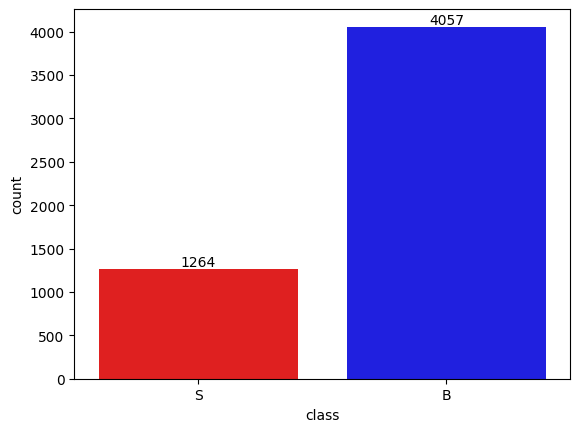

In [28]:
plt.figure()
colors={'B': 'blue', 'S': 'red'}
ax = sns.countplot(data=data, x="class", palette=colors)
for container in ax.containers:
    ax.bar_label(container)

plt.show()

## Encode characters to value

In [29]:
data["class"] = data["class"].map({"B": 0, "S": 1})

In [30]:
data.head(10)

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,WRITE_HISTORY_BOOKMARKS,TelephonyManager.getSubscriberId,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,1,1,1,1,1,0,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,0,1,1
6,0,1,1,0,1,1,0,0,0,0,...,0,1,1,0,1,1,0,1,1,1
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
8,0,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,1,0,0,0,1
9,1,0,0,1,0,1,1,1,0,0,...,0,0,1,0,1,1,0,1,1,1


In [31]:
X = data.drop("class", axis=1)
y = data["class"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4256, 50), (1065, 50), (4256,), (1065,))

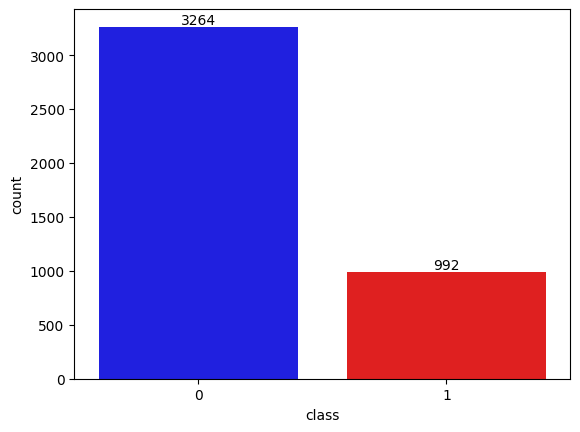

In [34]:
plt.figure()
colors={'0': 'blue', '1': 'red'}
ax = sns.countplot(x=y_train, palette=colors)

for container in ax.containers:
    ax.bar_label(container)

plt.show()

# Creating Multiple Models

## Logistic Regression Model

### Train the model

In [35]:
logreg = LogisticRegression(class_weight='balanced')
start = time.time()
logreg.fit(X_train, y_train)
end = time.time()
logreg_time = end - start
print("Logistic Regression Train Time:", logreg_time)

Logistic Regression Train Time: 0.0730140209197998


### Test the model and check the accuracy

In [36]:
logreg_pred_test = logreg.predict(X_test)

logreg_test_score = accuracy_score(logreg_pred_test, y_test)
print("Logistic Regression Test Score:", logreg_test_score)

Logistic Regression Test Score: 0.9070422535211268


### Check other forms of performance measurement methods

In [37]:
logreg_precision_score = precision_score(y_test, logreg_pred_test)
logreg_f1_score = f1_score(y_test, logreg_pred_test)
logreg_recall_score = recall_score(y_test, logreg_pred_test)
logreg_accuracy_score = accuracy_score(y_test, logreg_pred_test)

print("Logistic Regression Precision Score:", logreg_precision_score)
print("Logistic Regression Recall Score:", logreg_recall_score)
print("Logistic Regression F1 Score:", logreg_f1_score)
print("Logistic Regression Accuracy Score:", logreg_accuracy_score)

Logistic Regression Precision Score: 0.7678018575851393
Logistic Regression Recall Score: 0.9117647058823529
Logistic Regression F1 Score: 0.8336134453781513
Logistic Regression Accuracy Score: 0.9070422535211268


In [38]:
print(classification_report(y_test, logreg_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       793
           1       0.77      0.91      0.83       272

    accuracy                           0.91      1065
   macro avg       0.87      0.91      0.88      1065
weighted avg       0.92      0.91      0.91      1065



### Check the confusion matrix

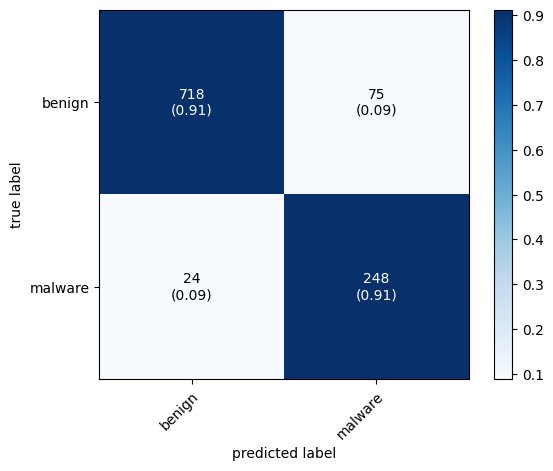

In [39]:
logreg_cm = confusion_matrix(y_test, logreg_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=logreg_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
plt.show()

### Save the model

In [41]:
dump(logreg, 'LogisticRegressionModel.joblib')

['LogisticRegressionModel.joblib']

## Random Forest Model

### Train the model

In [42]:
rf = RandomForestClassifier(class_weight='balanced')
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
rf_time = end - start
# X_train.columns
print("Random Forest Train Time:", rf_time)

Random Forest Train Time: 0.5390048027038574


### Test the model and check the accuracy

In [43]:
rf_pred_test = rf.predict(X_test)

rf_test_score = accuracy_score(rf_pred_test, y_test)
print("Random Forest Test Score:", rf_test_score)

Random Forest Test Score: 0.9427230046948357


### Check other forms of performance measurement methods

In [44]:
rf_precision_score = precision_score(y_test, rf_pred_test)
rf_f1_score = f1_score(y_test, rf_pred_test)
rf_recall_score = recall_score(y_test, rf_pred_test)
rf_accuracy_score = accuracy_score(y_test, rf_pred_test)

print("Random Forest Precision Score:", rf_precision_score)
print("Random Forest Recall Score:", rf_recall_score)
print("Random Forest F1 Score:", rf_f1_score)
print("Random Forest Accuracy Score:", rf_accuracy_score)

Random Forest Precision Score: 0.9236947791164659
Random Forest Recall Score: 0.8455882352941176
Random Forest F1 Score: 0.8829174664107485
Random Forest Accuracy Score: 0.9427230046948357


In [45]:
print(classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       793
           1       0.92      0.85      0.88       272

    accuracy                           0.94      1065
   macro avg       0.94      0.91      0.92      1065
weighted avg       0.94      0.94      0.94      1065



### Check the confusion matrix

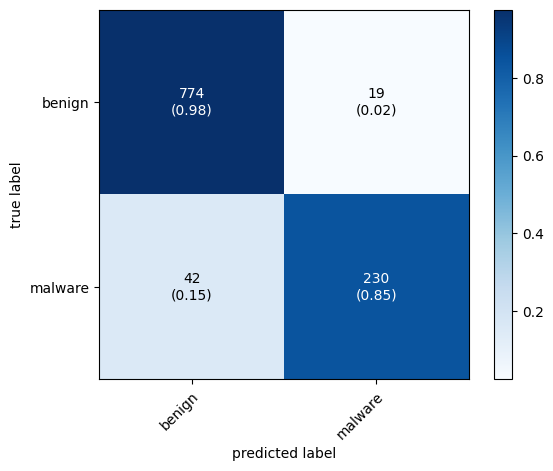

In [46]:
rf_cm = confusion_matrix(y_test, rf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=rf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
plt.show()

### Save the model

In [47]:
dump(rf, 'RandomForestModel.joblib')

['RandomForestModel.joblib']

## Decision Tree Model

### Train the model

In [48]:
dt = DecisionTreeClassifier(class_weight='balanced')
start = time.time()
dt.fit(X_train, y_train)
end = time.time()
dt_time = end - start
print("Decision Tree Train Time:", dt_time)

Decision Tree Train Time: 0.029018640518188477


### Test the model and check the accuracy

In [49]:
dt_pred_test = dt.predict(X_test)

dt_test_score = accuracy_score(dt_pred_test, y_test)
print("Decision Tree Test Score:", dt_test_score)

Decision Tree Test Score: 0.9004694835680751


### Check other forms of performance measurement methods

In [50]:
dt_precision_score = precision_score(y_test, dt_pred_test)
dt_f1_score = f1_score(y_test, dt_pred_test)
dt_recall_score = recall_score(y_test, dt_pred_test)
dt_accuracy_score = accuracy_score(y_test, dt_pred_test)

print("Decision Tree Precision Score:", dt_precision_score)
print("Decision Tree Recall Score:", dt_recall_score)
print("Decision Tree F1 Score:", dt_f1_score)
print("Decision Tree Accuracy Score:", dt_accuracy_score)

Decision Tree Precision Score: 0.8120300751879699
Decision Tree Recall Score: 0.7941176470588235
Decision Tree F1 Score: 0.8029739776951672
Decision Tree Accuracy Score: 0.9004694835680751


In [51]:
print(classification_report(y_test, dt_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       793
           1       0.81      0.79      0.80       272

    accuracy                           0.90      1065
   macro avg       0.87      0.87      0.87      1065
weighted avg       0.90      0.90      0.90      1065



### Check the confusion matrix

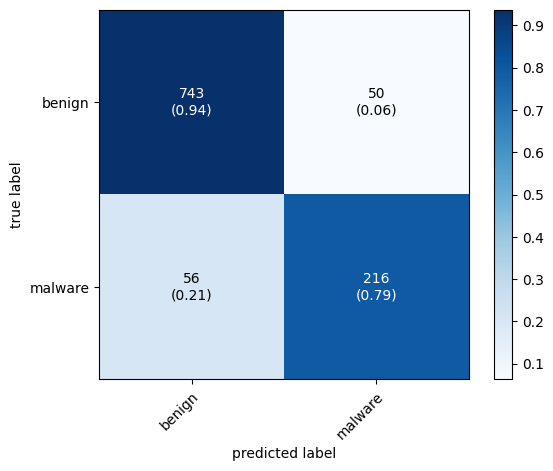

In [52]:
dt_cm = confusion_matrix(y_test, dt_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=dt_cm, show_absolute=True, 
                                show_normed=True, colorbar=True, 
                                class_names=["benign", "malware"])
plt.show()

### Save the model

In [53]:
dump(dt, 'DecisionTreeModel.joblib')

['DecisionTreeModel.joblib']

## Comparison of Models

### Test accuracy

In [67]:
X_train[y_train==1].sample(10).transpose().to_csv("malware.csv")

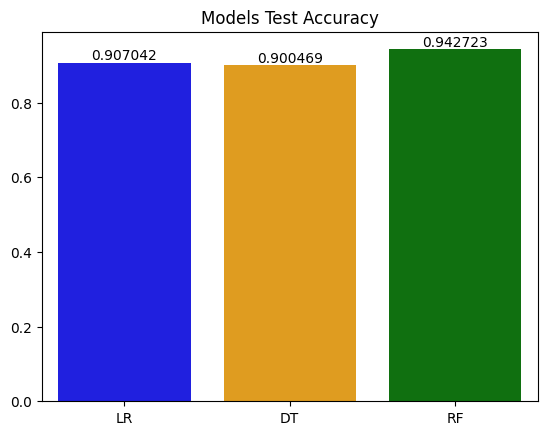

In [54]:
labels = ["LR", "DT", "RF"]
scores = [logreg_test_score, dt_test_score, rf_test_score]
colors={'DT':'orange', 'RF':'green', 'LR':'blue'}
plt.figure()
ax = sns.barplot(x=labels, y=scores, palette=colors)
ax.set_title("Models Test Accuracy")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

### Precision Score

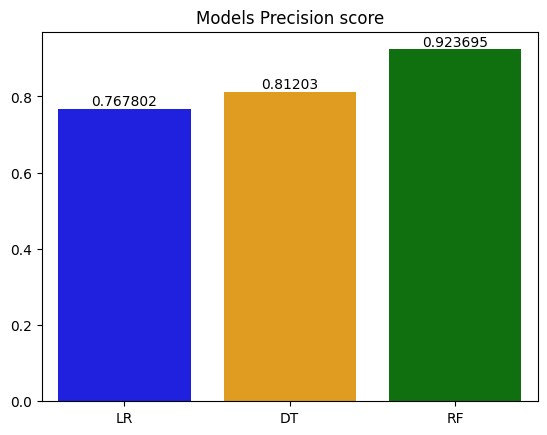

In [55]:
labels = ["LR", "DT", "RF"]
scores = [logreg_precision_score, dt_precision_score, rf_precision_score]
colors={'DT':'orange', 'RF':'green', 'LR':'blue'}
plt.figure()
ax = sns.barplot(x=labels, y=scores, palette=colors)
ax.set_title("Models Precision score")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

## Recall

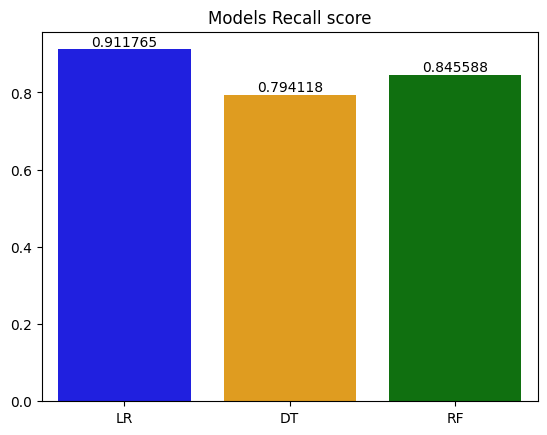

In [56]:
labels = ["LR", "DT", "RF"]
scores = [logreg_recall_score, dt_recall_score, rf_recall_score]
colors={'DT':'orange', 'RF':'green', 'LR':'blue'}
plt.figure()
ax = sns.barplot(x=labels, y=scores, palette=colors)
ax.set_title("Models Recall score")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

### F1 score

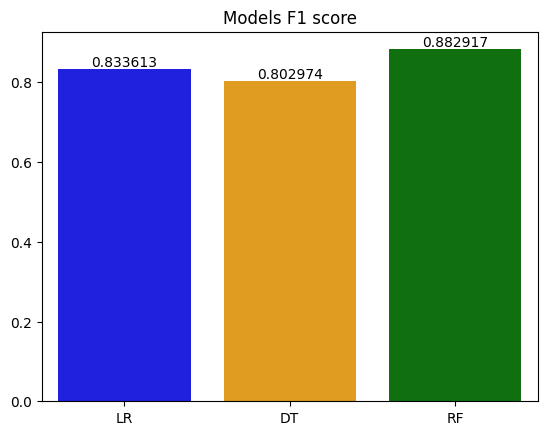

In [57]:
labels = ["LR", "DT", "RF"]
scores = [logreg_f1_score, dt_f1_score, rf_f1_score]
colors={'DT':'orange', 'RF':'green', 'LR':'blue'}
plt.figure()
ax = sns.barplot(x=labels, y=scores, palette=colors)
ax.set_title("Models F1 score")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

## Extraction and pre-processing of malicious application features

In [30]:
from androguard.core.bytecodes.apk import APK
from androguard.core.bytecodes.dvm import DalvikVMFormat

In [ ]:
from androguard.core.bytecodes.apk import APK
from androguard.core.bytecodes.dvm import DalvikVMFormat

def preprocessAPK(name):
    columns = ["filename"]
    for col in data.columns:
        columns.append(col)
    columns.remove("class")
    columns+=["class_lr", "class_dt", "class_rf"]
    test_df = pd.DataFrame(columns=columns)
    test_df.head(10)
    
    permissions_list = feature_df[feature_df["Category"] == "Manifest Permission"].X.unique()
    api_call_signatures = feature_df[feature_df["Category"] == "API call signature"].X.unique()
    intents = feature_df[feature_df["Category"] == "Intent"].X.unique()
    keywords = feature_df[feature_df["Category"] == "Commands signature"].X.unique()
    
    index=0
    test_df.loc[index, "filename"] = name
    test_df
    
    a = APK(test_df.loc[index, "filename"])
    d = DalvikVMFormat(a.get_dex())
    
    permissions = a.get_permissions()
    manifest = a.get_android_manifest_xml()
    intent_filters = manifest.findall(".//intent-filter")
    
    found_permissions = []
    found_api_signatures = []
    found_intents = []
    found_keywords = []
    
    for permission in permissions:
        permission = permission.split(".")[-1]
        if permission in permissions_list:
            found_permissions.append(permission)
    
    for permission in permissions_list:
        if permission in found_permissions:
            test_df[permission] = 1
        else:
            test_df[permission] = 0
    
    for method in d.get_methods():
        for api_call in api_call_signatures:
            if re.search(api_call.encode('utf-8'), method.get_descriptor()):
                found_api_signatures.append(api_call)
    
    for api_call in api_call_signatures:
        if api_call in found_api_signatures:
            test_df[api_call] = 1
        else:
            test_df[api_call] = 0
    
    for intent_filter in intent_filters:
        action_elements = intent_filter.findall(".//action")
        for action_element in action_elements:
            action_value = action_element.get("{http://schemas.android.com/apk/res/android}name")
            for intent in intents:
                if re.search(intent, action_value):
                    found_intents.append(intent)
    
    for intent in intents:
        if intent in found_intents:
            test_df[intent] = 1
        else:
            test_df[intent] = 0
    
    for method in d.get_methods():
        for keyword in keywords:
            try:
                if re.search(keyword, method.get_code().get_instruction()):
                    found_keywords.append(keyword)
            except:
                pass
    
    for keyword in keywords:
        if keyword in found_keywords:
            test_df[keyword] = 1
        else:
            test_df[keyword] = 0
    
    dropped = test_df.drop(["filename", "class_lr","class_dt","class_rf"], axis=1)
    return dropped

In [31]:
columns = ["filename"]
for col in data.columns:
    columns.append(col)
columns.remove("class")
columns+=["class_lr", "class_dt", "class_rf"]
test_df = pd.DataFrame(columns=columns)
test_df.head(10)

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder,class_lr,class_dt,class_rf


In [32]:
permissions_list = feature_df[feature_df["Category"] == "Manifest Permission"].X.unique()
api_call_signatures = feature_df[feature_df["Category"] == "API call signature"].X.unique()
intents = feature_df[feature_df["Category"] == "Intent"].X.unique()
keywords = feature_df[feature_df["Category"] == "Commands signature"].X.unique()

In [32]:
permissions_list.shape

(12,)

In [33]:
logreg = load('LogisticRegressionModel.joblib')
dt = load('DecisionTreeModel.joblib')
rf = load('RandomForestModel.joblib')

## Testing the malicious apps developed by us

In [34]:
index=0
name = 'Dhanera.apk'
test_df.loc[index, "filename"] = name
test_df

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder,class_lr,class_dt,class_rf
0,Dhanera.apk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
a = APK(test_df.loc[index, "filename"])
d = DalvikVMFormat(a.get_dex())

Requested API level 33 is larger than maximum we have, returning API level 28 instead.


In [36]:
permissions = a.get_permissions()
manifest = a.get_android_manifest_xml()
intent_filters = manifest.findall(".//intent-filter")

In [37]:
found_permissions = []
found_api_signatures = []
found_intents = []
found_keywords = []

In [38]:
for permission in permissions:
    permission = permission.split(".")[-1]
    if permission in permissions_list:
        found_permissions.append(permission)

In [39]:
for permission in permissions_list:
    if permission in found_permissions:
        test_df[permission] = 1
    else:
        test_df[permission] = 0

In [40]:
test_df.head()

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder,class_lr,class_dt,class_rf
0,Dhanera.apk,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [41]:
for method in d.get_methods():
    for api_call in api_call_signatures:
        if re.search(api_call.encode('utf-8'), method.get_descriptor()):
            found_api_signatures.append(api_call)

In [42]:
for api_call in api_call_signatures:
    if api_call in found_api_signatures:
        test_df[api_call] = 1
    else:
        test_df[api_call] = 0

In [43]:
test_df.head()

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder,class_lr,class_dt,class_rf
0,Dhanera.apk,0,0,0,0,1,0,0,0,0,...,NaN,0,0,0,0,0,1,NaN,NaN,NaN


In [44]:
for intent_filter in intent_filters:
    action_elements = intent_filter.findall(".//action")
    for action_element in action_elements:
        action_value = action_element.get("{http://schemas.android.com/apk/res/android}name")
        for intent in intents:
            if re.search(intent, action_value):
                found_intents.append(intent)

In [45]:
for intent in intents:
    if intent in found_intents:
        test_df[intent] = 1
    else:
        test_df[intent] = 0

In [46]:
test_df.head()

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder,class_lr,class_dt,class_rf
0,Dhanera.apk,0,0,0,0,1,0,0,0,0,...,NaN,0,0,0,0,0,1,NaN,NaN,NaN


In [47]:
for method in d.get_methods():
    for keyword in keywords:
        try:
            if re.search(keyword, method.get_code().get_instruction()):
                found_keywords.append(keyword)
        except:
            pass

In [48]:
for keyword in keywords:
    if keyword in found_keywords:
        test_df[keyword] = 1
    else:
        test_df[keyword] = 0

In [49]:
test_df.head()

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder,class_lr,class_dt,class_rf
0,Dhanera.apk,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,NaN,NaN,NaN


In [50]:
dropped = test_df.drop(["filename", "class_lr","class_dt","class_rf"], axis=1)
dropped

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,android.telephony.gsm.SmsManager,WRITE_HISTORY_BOOKMARKS,TelephonyManager.getSubscriberId,mount,INSTALL_PACKAGES,Runtime.getRuntime,Ljava.lang.Object.getClass,READ_HISTORY_BOOKMARKS,Ljava.lang.Class.forName,Binder
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
dropped.transpose()

,0
transact,0
onServiceConnected,0
bindService,0
attachInterface,0
ServiceConnection,1
android.os.Binder,0
SEND_SMS,0
Ljava.lang.Class.getCanonicalName,0
Ljava.lang.Class.getMethods,0
Ljava.lang.Class.cast,0


[0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1]

In [52]:
test_df.loc[test_df['filename']==name, 'class_lr'] = logreg.predict(dropped)
test_df.loc[test_df['filename']==name, 'class_rf'] = rf.predict(dropped)
test_df.loc[test_df['filename']==name, 'class_dt'] = dt.predict(dropped)

In [53]:
test_df[['class_lr', 'class_dt', 'class_rf']]

,class_lr,class_dt,class_rf
0,1,1,0


In [54]:
import random

## Verifing the accuracy of models with existing data

### With class is 1, which indicates malicious

In [55]:
new_df = data[data["class"] == 1]
new_test=new_df.loc[random.randint(0, len(new_df)), :].drop("class")
new_test.shape

KeyError: 0

In [ ]:
rf.predict([new_test])

array([1], dtype=int64)

In [ ]:
dt.predict([new_test])

array([1], dtype=int64)

In [ ]:
logreg.predict([new_test])

array([1], dtype=int64)

### With class is 0, which indicates genuine

In [ ]:
new_df = data[data["class"] == 0]
new_test=new_df.loc[random.randint(0, len(new_df)), :].drop("class")
new_test.shape

(50,)

In [ ]:
rf.predict([new_test])

array([0], dtype=int64)

In [ ]:
dt.predict([new_test])

array([0], dtype=int64)

In [ ]:
logreg.predict([new_test])

array([0], dtype=int64)